Here, we'll revisit the example from [Lensing degeneracies and mass substructure](https://ui.adsabs.harvard.edu/abs/2012MNRAS.425.1772L/abstract)
about the generalized mass sheet degeneracy, where different sources are rescaled
with different factors. The procedure that is used to extrapolate the lens
potential can also be used to make sure the deflection field at the positions of the
images are those to get the correct source rescalings.

In [1]:
%matplotlib inline

In [2]:
from grale.all_nb import *
feedback.setDefaultFeedback("none")

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec
Set feedback style to 'notebook'


In [3]:
# We'll use the same example as in the article, these are the settings for the
# cosmological model that were used
cosm = cosmology.Cosmology(0.7, 0.27, 0, 0.73)
cosmology.setDefaultCosmology(cosm)
D = cosm.getAngularDiameterDistance

In [4]:
# Lens and source redshifts
zd = 0.5
zs1 = 1.2
zs2 = 1.8

In [5]:
# The lens used was an NSIE, sources were ellipical shapes
nsie = lenses.NSIELens(D(zd), {"velocityDispersion": 1300000, "coreRadius": 1.5*ANGLE_ARCSEC, "ellipticity": 0.8})

pos1, sz1 = V(10,5)*ANGLE_ARCSEC, 1.1*ANGLE_ARCSEC
pos2, sz2 = V(2, -4.5)*ANGLE_ARCSEC, 0.8*ANGLE_ARCSEC

src1 = images.EllipticalSource(pos1, sz1, 0.6, 30)
src2 = images.EllipticalSource(pos2, sz2, 0.4, 110)

li = plotutil.LensInfo(nsie, size=80*ANGLE_ARCSEC, zd=zd)
# This one has more detail, to get the points of the smaller images with more accuracy
liDetail = plotutil.LensInfo(nsie, size=80*ANGLE_ARCSEC, zd=zd, numxy=2047)

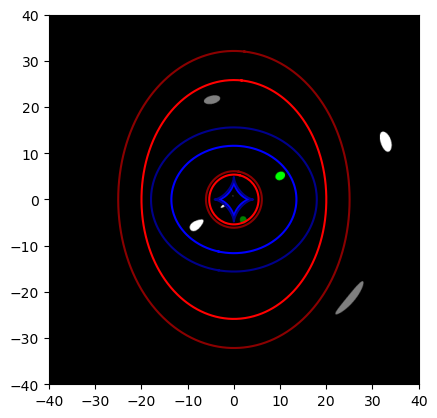

In [6]:
# Plot the image planes for the two sources
plotutil.plotImagePlane(li, sources=[{"shape": src1, "z": zs1}, {"shape": src2, "z": zs2}],
                        critColor=["red", "darkred"], caustColor=["blue", "darkblue"],
                        imageRgb=[(1,1,1),(0.5,0.5,0.5)],
                        sourceRgb=[(0,1,0),(0,0.5,0)])

In [7]:
# Critical densities for each source redshift
critDens1 = lenses.getCriticalDensity(D(zd), D(zs1), D(zd, zs1))
critDens2 = lenses.getCriticalDensity(D(zd), D(zs2), D(zd, zs2))

In [8]:
# Based on the plot above, get the different images as ImagesData objects.
# These will be needed when using the extrapolation procedure, to mark the
# image regions.
def getImageData(li, srcShape, zs):
    li.setSourceRedshift(zs)
    ip = li.getImagePlane()
    segs = ip.segment(ip.renderImages([srcShape]))
    
    imgData = images.ImagesData(len(segs))
    for idx, seg in enumerate(segs):
        for pt in seg:
            imgData.addPoint(idx, pt)
    return imgData

imgDat1 = getImageData(liDetail, src1, zs1)
imgDat2 = getImageData(liDetail, src2, zs2)

In [9]:
# We'll abuse an InversionWorkSpace to be able to backproject these images to their
# source planes.
iws = inversion.InversionWorkSpace(zd, 80*ANGLE_ARCSEC)
iws.addImageDataToList(imgDat1, zs1, "extendedimages")
iws.addImageDataToList(imgDat2, zs2, "extendedimages")

In [10]:
# This is a helper function to be able to easily create a lens where source 1 is
# rescaled by factor 'lambda1', and source 2 by 'lambda2'.
#
# Internally, we'll create a simple MSD lens that would work for each source
# separately, that will give the required constraints for the deflection field,
# at the positions of the images. The lens potential extrapolation can then look
# for a valid model that satisfies those constraints. Really exact constraints
# for this usually don't work, so we'll do an approximation where the target
# values should be reached within some tolerance.
#
# There aren't really any lens potential values that need to be fixed, but to make
# sure the procedure has a good starting point, a single value is set. The starting
# model is still set to the NSIE lens, that helps set scale values for the routine.
# Also, depending on the solver, this lens' potential values may be used as a starting
# point for the optimization routine.

def getMultiMSDLensAndSources(lambda1, lambda2, HW, N, potGradWeight, exactDeflectionTolerance, solver):

    sheet1 = lenses.MassSheetLens(D(zd), {"density": critDens1})
    sheet2 = lenses.MassSheetLens(D(zd), {"density": critDens2})

    msd1 = lenses.CompositeLens(D(zd),[
        { "lens": nsie, "factor": lambda1, "angle": 0, "x": 0, "y": 0 },
        { "lens": sheet1, "factor": (1.0-lambda1), "angle": 0, "x": 0, "y": 0 },
    ])
    msd2 = lenses.CompositeLens(D(zd),[
        { "lens": nsie, "factor": lambda2, "angle": 0, "x": 0, "y": 0 },
        { "lens": sheet2, "factor": (1.0-lambda2), "angle": 0, "x": 0, "y": 0 },
    ])
    
    tr = V(HW,HW)*ANGLE_ARCSEC
    bl = -tr
    _, img1Mask = util.createThetaGridAndImagesMask(bl, tr, N, N, [ imgDat1 ])
    _, img2Mask = util.createThetaGridAndImagesMask(bl, tr, N, N, [ imgDat2 ])
    
    #plt.imshow(img1Mask|img2Mask)
    
    dummyMask = np.zeros((N,N), dtype=bool)
    dummyMask[N//2,N//2] = True
    
    r = lenses.createEquivalentPotentialGridLens(nsie, bl, tr, N, N, [ dummyMask ],
                                             potGradWeight, 1, 0,
                                             pixelEnlargements=0, # Needed to make sure we only start from 1 value
                                             qpsolver=solver,
                                             exactDeflectionConstraints=[
                                                 { "maskRegions": [ img1Mask ], "lens": msd1 },
                                                 { "maskRegions": [ img2Mask ], "lens": msd2 },
                                             ],
                                             exactDeflectionTolerance=exactDeflectionTolerance,
                                             feedbackObject="stdout"
                                            )
    
    newLens = r["philens_equiv"]
    # Rescaling is towards (0,0), which makes the new position easy
    src1New = images.EllipticalSource(pos1*lambda1, sz1*lambda1, 0.6, 30)
    src2New = images.EllipticalSource(pos2*lambda2, sz2*lambda2, 0.4, 110)
    return newLens, src1New, src2New

In [11]:
# Different lambda1 and lambda2 scale values that will be explored:
# - 1, 1:     no rescaling of the sources is used, leads to a lens that has the same effect as the original NSIE
# - 0.75, 1:  these were the settings used in the article
# - 0.9, 0.8: just some other scale factors, different for each source
lambdas=[ [1, 1], [0.75, 1], [0.9, 0.8] ]

In [12]:
newLens, src1New, src2New = getMultiMSDLensAndSources(*lambdas[0], 50, 256, 0.00002, 0.1*ANGLE_ARCSEC, "scs")

STATUS: Calculating lens potential values
STATUS: Calculating linear constraints
STATUS: Calculating quadratic optimization matrices
STATUS: Solving quadratic programming problem
STATUS: Done, in 18.9 seconds


In [13]:
newLens2, src1New2, src2New2 = getMultiMSDLensAndSources(*lambdas[1], 50, 256, 0.00002, 0.1*ANGLE_ARCSEC, "scs")

STATUS: Calculating lens potential values
STATUS: Calculating linear constraints
STATUS: Calculating quadratic optimization matrices
STATUS: Solving quadratic programming problem
STATUS: Done, in 18.7 seconds


In [14]:
newLens3, src1New3, src2New3 = getMultiMSDLensAndSources(*lambdas[2], 50, 256, 0.00002, 0.1*ANGLE_ARCSEC, "scs")

STATUS: Calculating lens potential values
STATUS: Calculating linear constraints
STATUS: Calculating quadratic optimization matrices
STATUS: Solving quadratic programming problem
STATUS: Done, in 18.9 seconds


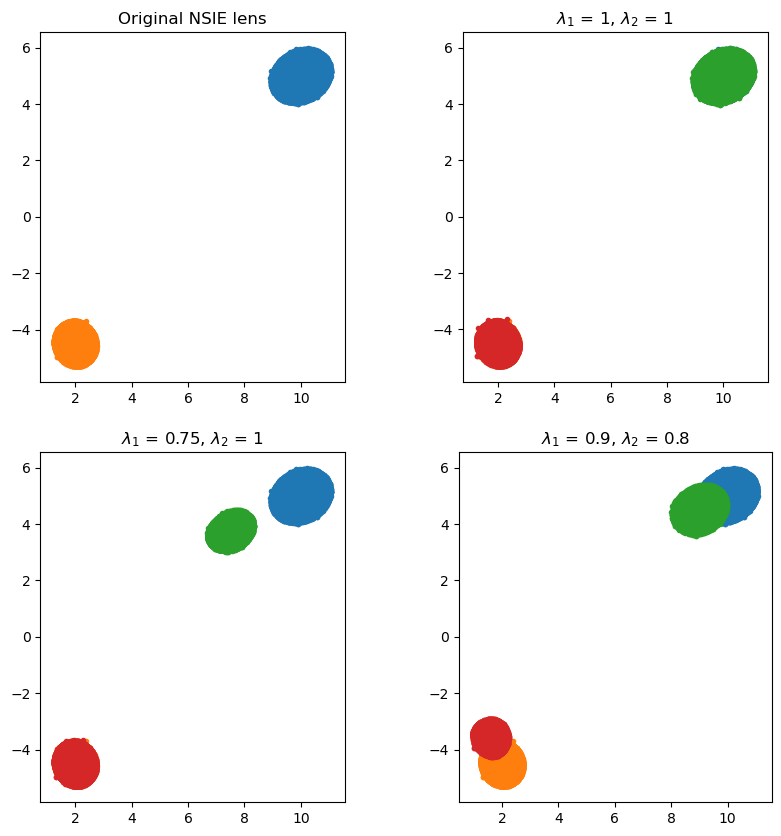

In [15]:
# For the original lens as well as the different extrapolated versions, back-project
# the images to their source planes. In each plot, the back-projection with the
# input lens is shown as well, so it is clear which sources have been rescaled.
#
# Since a simple MSD lens was used to get the required deflection angles, the rescaling
# is always done towards the origin.
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("Original NSIE lens")
plotutil.plotImagesData(iws.backProject(nsie))
plt.gca().set_aspect("equal")
plt.subplot(2,2,2)
plt.title("$\lambda_1$ = {}, $\lambda_2$ = {}".format(*lambdas[0]))
plotutil.plotImagesData(iws.backProject(nsie))
plotutil.plotImagesData(iws.backProject(newLens))
plt.gca().set_aspect("equal")
plt.subplot(2,2,3)
plt.title("$\lambda_1$ = {}, $\lambda_2$ = {}".format(*lambdas[1]))
plotutil.plotImagesData(iws.backProject(nsie))
plotutil.plotImagesData(iws.backProject(newLens2))
plt.gca().set_aspect("equal")
plt.subplot(2,2,4)
plt.title("$\lambda_1$ = {}, $\lambda_2$ = {}".format(*lambdas[2]))
plotutil.plotImagesData(iws.backProject(nsie))
plotutil.plotImagesData(iws.backProject(newLens3))
plt.gca().set_aspect("equal")

In [16]:
liNew = plotutil.LensInfo(newLens, size=80*ANGLE_ARCSEC,zd=zd)
liNew2 = plotutil.LensInfo(newLens2, size=80*ANGLE_ARCSEC,zd=zd)
liNew3 = plotutil.LensInfo(newLens3, size=80*ANGLE_ARCSEC,zd=zd)

In [17]:
# This is the result for lambda1=1 and lambda2=1, so has the same
# effect as the original NSIE
plotutil.plotDensityInteractive(liNew, densityUnit=critDens1)

In [18]:
# This one causes source 1 to be rescaled by 0.75, source 2 is kept at its size/position.
# This was the case used in the article
plotutil.plotDensityInteractive(liNew2, densityUnit=critDens1)

In [19]:
# Here, source 1 is scaled by 0.9, and source 2 by 0.8
plotutil.plotDensityInteractive(liNew3, densityUnit=critDens1)

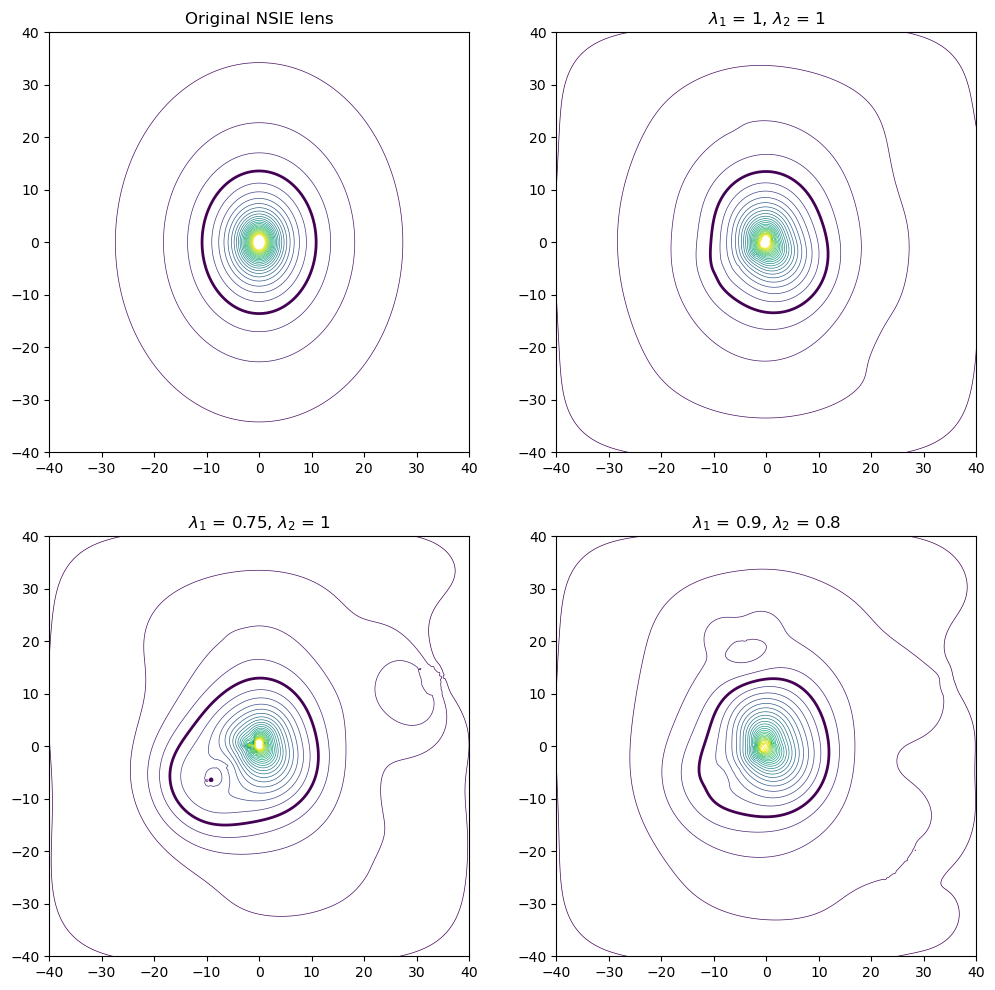

In [20]:
# Contour plots of the mass densities of each case
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.title("Original NSIE lens")
plotutil.plotDensityContours(li, densityUnit=critDens1, levels=np.arange(0.2, 6, 0.2),linewidths=0.5)
plotutil.plotDensityContours(li, densityUnit=critDens1, levels=[1], linewidths=2)
plt.subplot(2,2,2)
plt.title("$\lambda_1$ = {}, $\lambda_2$ = {}".format(*lambdas[0]))
plotutil.plotDensityContours(liNew, densityUnit=critDens1, levels=np.arange(0.2, 6, 0.2),linewidths=0.5)
plotutil.plotDensityContours(liNew, densityUnit=critDens1, levels=[1], linewidths=2)
plt.subplot(2,2,3)
plt.title("$\lambda_1$ = {}, $\lambda_2$ = {}".format(*lambdas[1]))
plotutil.plotDensityContours(liNew2, densityUnit=critDens1, levels=np.arange(0.2, 6, 0.2),linewidths=0.5)
plotutil.plotDensityContours(liNew2, densityUnit=critDens1, levels=[1], linewidths=2)
plt.subplot(2,2,4)
plt.title("$\lambda_1$ = {}, $\lambda_2$ = {}".format(*lambdas[2]))
plotutil.plotDensityContours(liNew3, densityUnit=critDens1, levels=np.arange(0.2, 6, 0.2),linewidths=0.5)
plotutil.plotDensityContours(liNew3, densityUnit=critDens1, levels=[1], linewidths=2)

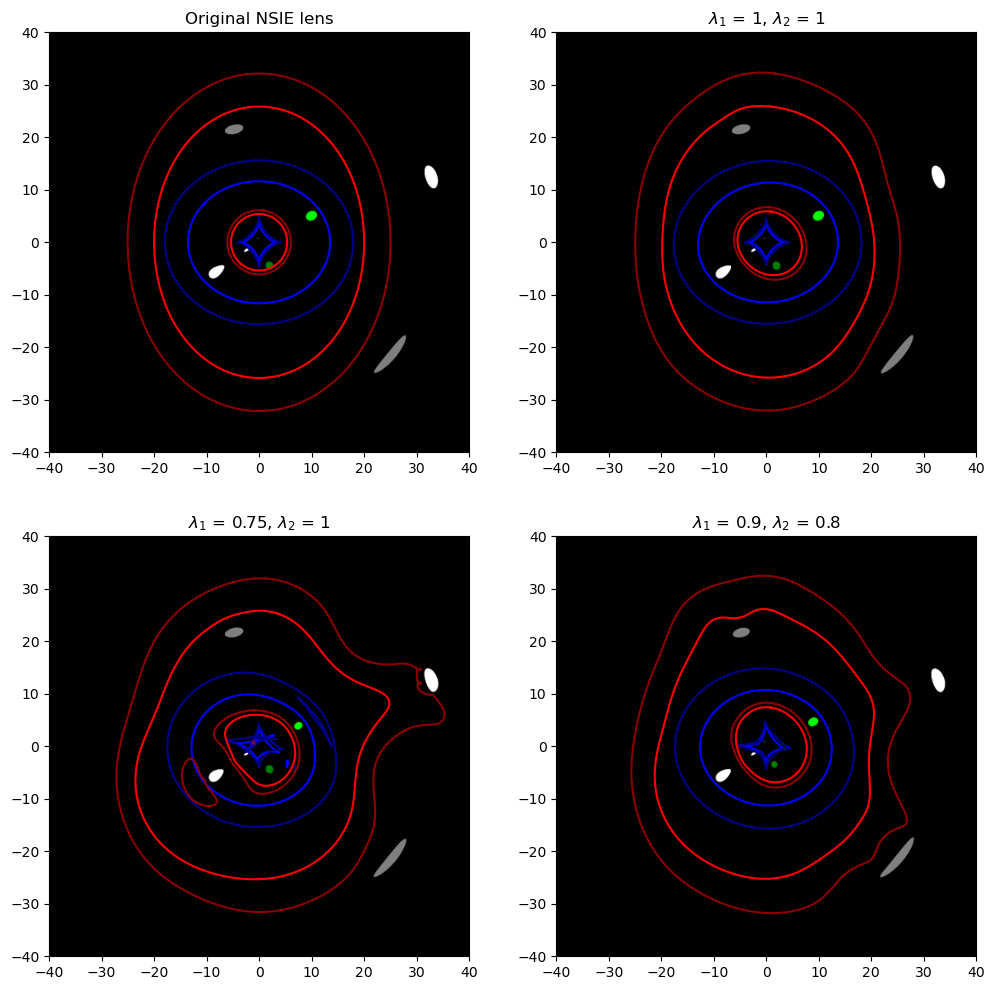

In [21]:
# Image planes of each situation, where the rescaled sources are used together 
# with their corresponding lens models. The generated images in each case will
# not be the same exactly, but up to a very good approximation.
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.title("Original NSIE lens")
plotutil.plotImagePlane(li, sources=[{"shape": src1, "z": zs1},
                                     {"shape": src2, "z": zs2}], 
                        critColor=["red", "darkred"], caustColor=["blue", "darkblue"],
                        imageRgb=[(1,1,1),(0.5,0.5,0.5)],
                        sourceRgb=[(0,1,0),(0,0.5,0)])
plt.subplot(2,2,2)
plt.title("$\lambda_1$ = {}, $\lambda_2$ = {}".format(*lambdas[0]))
plotutil.plotImagePlane(liNew, sources=[{"shape": src1New, "z": zs1},
                                        {"shape": src2New, "z": zs2}],
                        critColor=["red", "darkred"], caustColor=["blue", "darkblue"],
                        imageRgb=[(1,1,1),(0.5,0.5,0.5)],
                        sourceRgb=[(0,1,0),(0,0.5,0)])
plt.subplot(2,2,3)
plt.title("$\lambda_1$ = {}, $\lambda_2$ = {}".format(*lambdas[1]))
plotutil.plotImagePlane(liNew2, sources=[{"shape": src1New2, "z": zs1},
                                         {"shape": src2New2, "z": zs2}],
                        critColor=["red", "darkred"], caustColor=["blue", "darkblue"],
                        imageRgb=[(1,1,1),(0.5,0.5,0.5)],
                        sourceRgb=[(0,1,0),(0,0.5,0)])
plt.subplot(2,2,4)
plt.title("$\lambda_1$ = {}, $\lambda_2$ = {}".format(*lambdas[2]))
plotutil.plotImagePlane(liNew3, sources=[{"shape": src1New3, "z": zs1},
                                         {"shape": src2New3, "z": zs2}],
                        critColor=["red", "darkred"], caustColor=["blue", "darkblue"],
                        imageRgb=[(1,1,1),(0.5,0.5,0.5)],
                        sourceRgb=[(0,1,0),(0,0.5,0)])